This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# xarray furuno backend

In this example, we read scn/scnx (furuno) data files using the wradlib `furuno` xarray backend.

Furuno Weather Radars generate binary files. The binary version depend on the radar type. This reader is able to consume SCN (format version 3) and SCNX (format version 10) files. 

Uncompressed files are read via ``numpy.memmap`` with lazy-loading mechanism. Gzip compressed files are are opened, read into memory and processed using ``numpy.frombuffer``.

Radar moments are read as packed data with 16-bit resolution and output as 32bit-floating point data.

In [1]:
import glob
import gzip
import io
import wradlib as wrl
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as pl
import numpy as np
import xarray as xr

try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    pl.ion()

/home/runner/micromamba-root/envs/wradlib-tests/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load furuno scn Data

Data provided by University of Graz, Austria.

In [2]:
fpath = "furuno/0080_20210730_160000_01_02.scn.gz"
f = wrl.util.get_wradlib_data_file(fpath)
vol = wrl.io.open_furuno_dataset(f, reindex_angle=False)

In [3]:
vol[0]

<xarray.Dataset>
Dimensions:            (azimuth: 1376, range: 602)
Coordinates:
  * azimuth            (azimuth) float32 0.21 0.47 0.74 ... 359.4 359.7 359.9
    elevation          (azimuth) float32 ...
  * range              (range) float32 25.0 75.0 125.0 ... 3.002e+04 3.008e+04
    rtime              (azimuth) datetime64[ns] ...
    sweep_mode         <U20 ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
    time               datetime64[ns] 2021-07-30T16:00:00.005416500
Data variables: (12/13)
    RATE               (azimuth, range) float32 ...
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    PHIDP              (azimuth, range) float32 ...
    ...                 ...
    WRADH              (azimuth, range) float32 ...
    QUAL               (azimuth, range) uint16 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...
Attributes:
    fixed_angle:  7.8

### Inspect RadarVolume

In [4]:
display(vol)

<wradlib.RadarVolume>
Dimension(s): (sweep: 1)
Elevation(s): (7.8)

### Inspect root group

The `sweep` dimension contains the number of scans in this radar volume. Further the dataset consists of variables (location coordinates, time_coverage) and attributes (Conventions, metadata).

In [5]:
vol.root

<xarray.Dataset>
Dimensions:              (sweep: 1)
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2021-07-30T16:00:00Z'
    time_coverage_end    <U20 '2021-07-30 16:00:15Z'
    latitude             float64 ...
    longitude            float64 ...
    altitude             float64 ...
    sweep_group_name     (sweep) <U7 'sweep_0'
    sweep_fixed_angle    (sweep) float64 7.8
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    fixed_angle:      7.8

### Inspect sweep group(s)

The sweep-groups can be accessed via their respective keys. The dimensions consist of `range` and `time` with added coordinates `azimuth`, `elevation`, `range` and `time`. There will be variables like radar moments (DBZH etc.) and sweep-dependend metadata (like `fixed_angle`, `sweep_mode` etc.).

In [6]:
display(vol[0])

<xarray.Dataset>
Dimensions:            (azimuth: 1376, range: 602)
Coordinates:
  * azimuth            (azimuth) float32 0.21 0.47 0.74 ... 359.4 359.7 359.9
    elevation          (azimuth) float32 ...
  * range              (range) float32 25.0 75.0 125.0 ... 3.002e+04 3.008e+04
    rtime              (azimuth) datetime64[ns] 2021-07-30T16:00:06.277723500...
    sweep_mode         <U20 ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
    time               datetime64[ns] 2021-07-30T16:00:00.005416500
Data variables: (12/13)
    RATE               (azimuth, range) float32 ...
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    PHIDP              (azimuth, range) float32 ...
    ...                 ...
    WRADH              (azimuth, range) float32 ...
    QUAL               (azimuth, range) uint16 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 7.8
Attributes:
    fixed_angle:  7.8

### Goereferencing

In [7]:
swp = vol[0].copy().pipe(wrl.georef.georeference_dataset)

### Plotting

Currently the data dynamic range is left as read from the file. That way the difference between shortpulse and longpulse can be clearly seen.

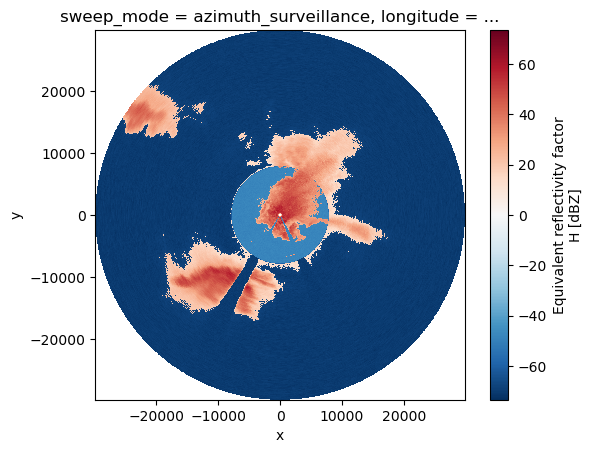

In [8]:
swp.DBZH.plot.pcolormesh(x="x", y="y")
pl.gca().set_aspect("equal")

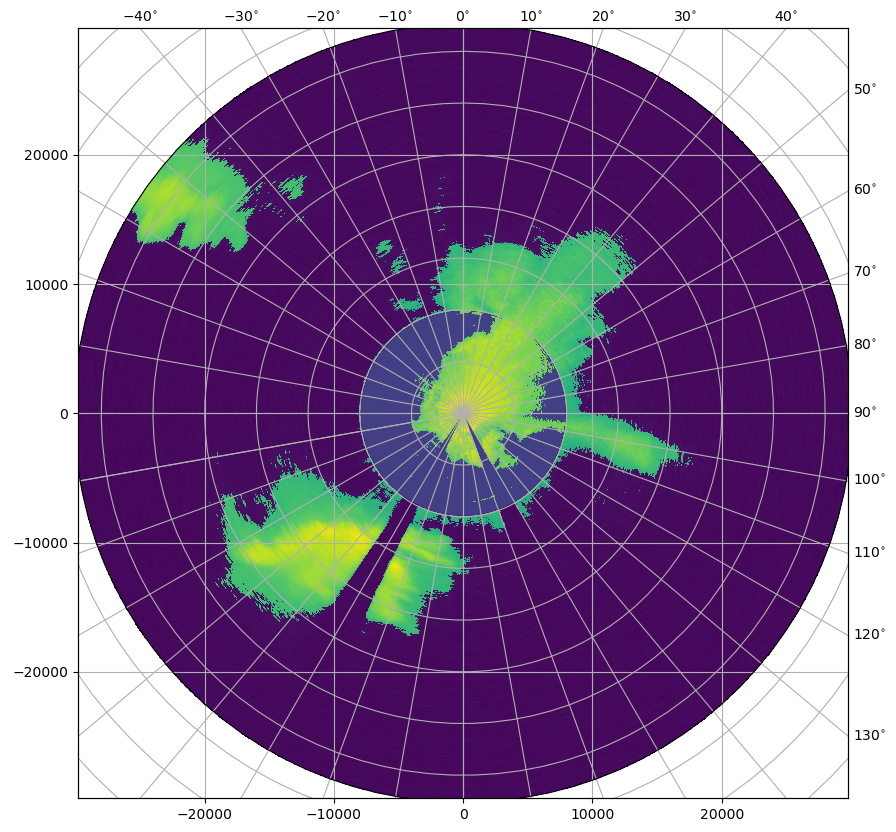

In [9]:
fig = pl.figure(figsize=(10, 10))
swp.DBZH.wradlib.plot_ppi(proj="cg", fig=fig)

In [10]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

map_trans = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values, central_longitude=swp.longitude.values
)

< GeoAxes: +proj=aeqd +ellps=WGS84 +lon_0=15.44729 +lat_0=47.07734000000001 +x_0=0.0 +y_0=0.0 +no_defs +type=crs >


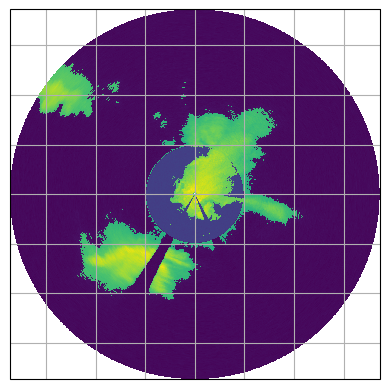

In [11]:
map_proj = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values, central_longitude=swp.longitude.values
)
pm = swp.DBZH.wradlib.plot_ppi(proj=map_proj)
ax = pl.gca()
ax.gridlines(crs=map_proj)
print(ax)

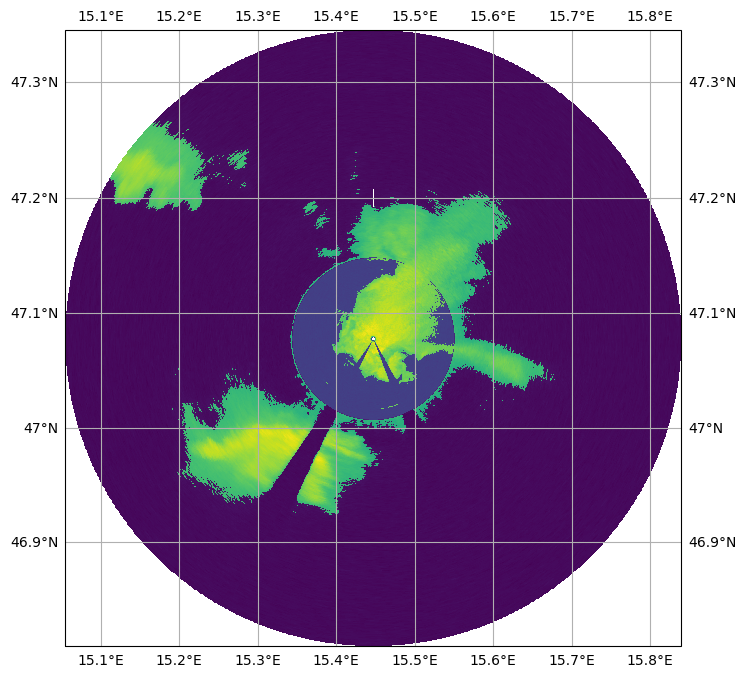

In [12]:
map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)
pm = swp.DBZH.wradlib.plot_ppi(ax=ax)
ax.gridlines(draw_labels=True)

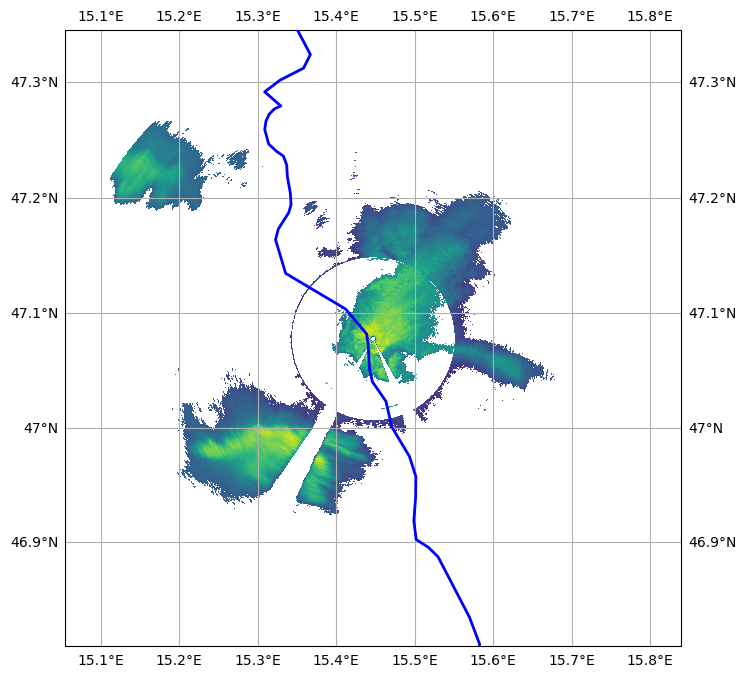

In [13]:
import cartopy.feature as cfeature


def plot_rivers(ax):
    rivers = cfeature.NaturalEarthFeature(
        category="physical",
        name="rivers_lake_centerlines",
        scale="10m",
        facecolor="none",
    )
    ax.add_feature(rivers, edgecolor="blue", lw=2, zorder=4)


map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)

DBZH = swp.DBZH
pm = DBZH.where(DBZH > 0).wradlib.plot_ppi(ax=ax)
plot_rivers(ax)
ax.gridlines(draw_labels=True)

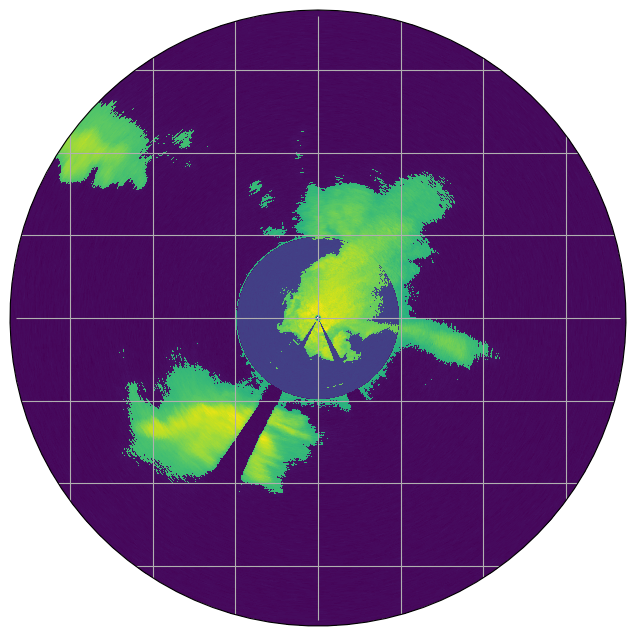

In [14]:
import matplotlib.path as mpath

theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

map_proj = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values,
    central_longitude=swp.longitude.values,
)
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)
ax.set_boundary(circle, transform=ax.transAxes)

pm = swp.DBZH.wradlib.plot_ppi(proj=map_proj, ax=ax)
ax = pl.gca()
ax.gridlines(crs=map_proj)

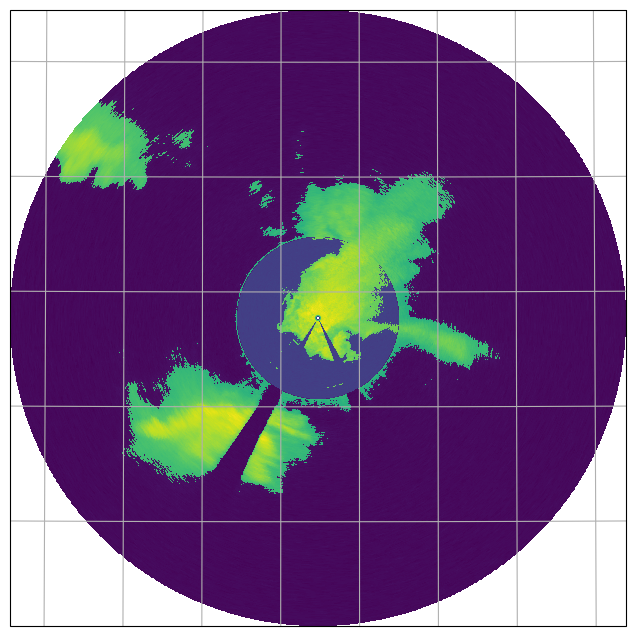

In [15]:
fig = pl.figure(figsize=(10, 8))
proj = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values, central_longitude=swp.longitude.values
)
ax = fig.add_subplot(111, projection=proj)
pm = swp.DBZH.wradlib.plot_ppi(ax=ax)
ax.gridlines()

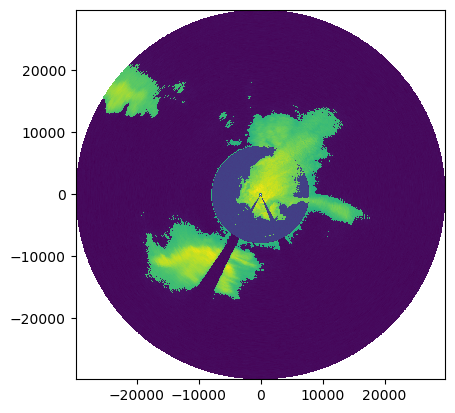

In [16]:
swp.DBZH.wradlib.plot_ppi()

### Inspect radar moments

The DataArrays can be accessed by key or by attribute. Each DataArray has dimensions and coordinates of it's parent dataset.

In [17]:
display(swp.DBZH)

<xarray.DataArray 'DBZH' (azimuth: 1376, range: 602)>
array([[       nan,        nan,        nan, ..., -70.70001 , -70.19    ,
        -70.07001 ],
       [       nan,        nan,        nan, ..., -70.98999 , -70.28    ,
        -70.26999 ],
       [       nan,        nan,        nan, ..., -70.78    , -70.26001 ,
        -70.31    ],
       ...,
       [       nan,        nan,        nan, ..., -70.04001 , -70.389984,
        -69.369995],
       [       nan,        nan,        nan, ..., -69.81    , -70.17001 ,
        -69.600006],
       [       nan,        nan,        nan, ..., -69.95999 , -69.98999 ,
        -69.98001 ]], dtype=float32)
Coordinates: (12/15)
  * azimuth     (azimuth) float32 0.21 0.47 0.74 1.0 ... 359.2 359.4 359.7 359.9
    elevation   (azimuth) float32 7.8 7.8 7.8 7.8 7.8 ... 7.8 7.8 7.8 7.8 7.8
  * range       (range) float32 25.0 75.0 125.0 ... 3.002e+04 3.008e+04
    rtime       (azimuth) datetime64[ns] 2021-07-30T16:00:06.277723500 ... 20...
    sweep_mode  <U20 'azimuth_surveillance'
    longitude   float64 15.45
    ...          ...
    x           (azimuth, range) float32 0.09078 0.2723 0.4539 ... -31.13 -31.18
    y           (azimuth, range) float32 24.77 74.3 ... 2.973e+04 2.978e+04
    z           (azimuth, range) float32 411.0 418.0 ... 4.535e+03 4.542e+03
    gr          (azimuth, range) float32 24.77 74.3 ... 2.973e+04 2.978e+04
    rays        (azimuth, range) float32 0.21 0.21 0.21 ... 359.9 359.9 359.9
    bins        (azimuth, range) float32 25.0 75.0 125.0 ... 3.002e+04 3.008e+04
Attributes:
    units:          dBZ
    standard_name:  radar_equivalent_reflectivity_factor_h
    long_name:      Equivalent reflectivity factor H
    coordinates:    elevation azimuth range latitude longitude altitude time ...

### Create simple plot

Using xarray features a simple plot can be created like this. Note the `sortby('rtime')` method, which sorts the radials by time.

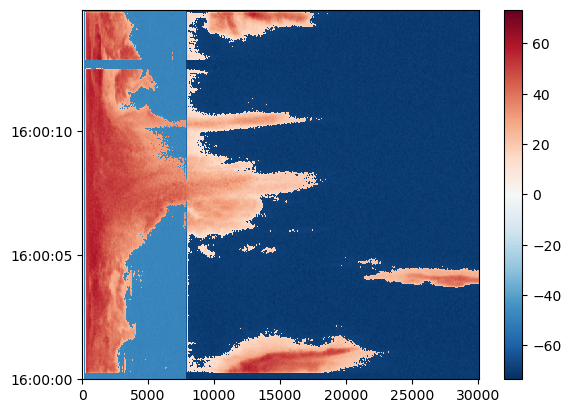

In [18]:
swp.DBZH.sortby("rtime").plot(x="range", y="rtime", add_labels=False)

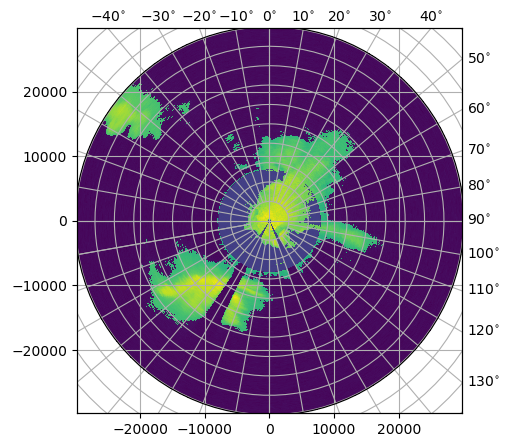

In [19]:
fig = pl.figure(figsize=(5, 5))
pm = swp.DBZH.wradlib.plot_ppi(proj={"latmin": 3e3}, fig=fig)

### Mask some values

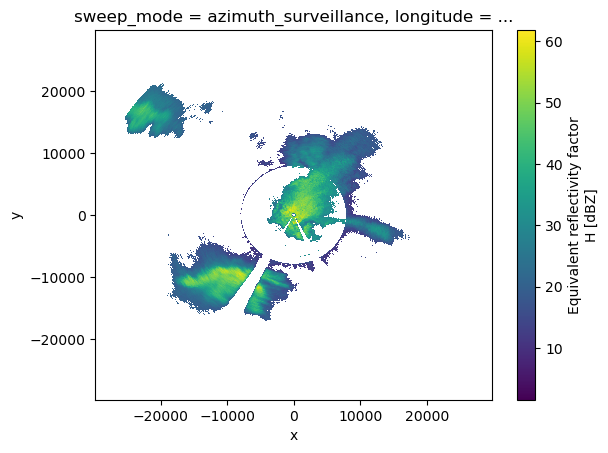

In [20]:
dbzh = swp["DBZH"].where(swp["DBZH"] >= 0)
dbzh.plot(x="x", y="y")

In [21]:
vol[0]

<xarray.Dataset>
Dimensions:            (azimuth: 1376, range: 602)
Coordinates:
  * azimuth            (azimuth) float32 0.21 0.47 0.74 ... 359.4 359.7 359.9
    elevation          (azimuth) float32 ...
  * range              (range) float32 25.0 75.0 125.0 ... 3.002e+04 3.008e+04
    rtime              (azimuth) datetime64[ns] 2021-07-30T16:00:06.277723500...
    sweep_mode         <U20 ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
    time               datetime64[ns] 2021-07-30T16:00:00.005416500
Data variables: (12/13)
    RATE               (azimuth, range) float32 ...
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    PHIDP              (azimuth, range) float32 ...
    ...                 ...
    WRADH              (azimuth, range) float32 ...
    QUAL               (azimuth, range) uint16 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 7.8
Attributes:
    fixed_angle:  7.8

### Export to ODIM and CfRadial2


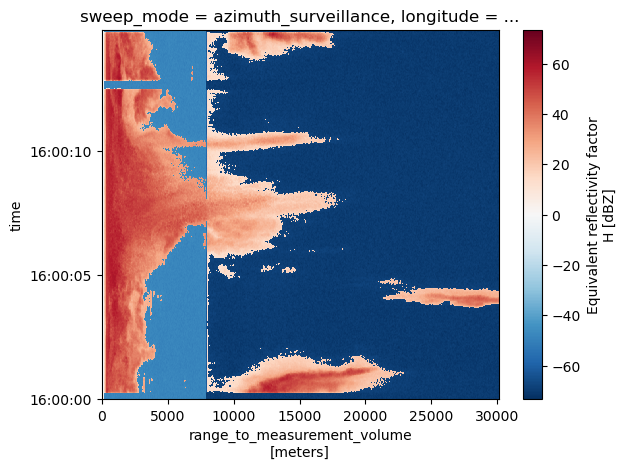

In [22]:
vol[0].DBZH.sortby("rtime").plot(y="rtime")

In [23]:
vol.to_odim("furuno_scn_as_odim.h5")
vol.to_cfradial2("furuno_scn_as_cfradial2.nc")

### Import again

<xarray.Dataset>
Dimensions:              (sweep: 1)
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2021-07-30T16:00:00Z'
    time_coverage_end    <U20 '2021-07-30 16:00:15Z'
    latitude             float64 ...
    longitude            float64 ...
    altitude             float64 ...
    sweep_group_name     (sweep) <U7 'sweep_0'
    sweep_fixed_angle    (sweep) float64 7.8
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    fixed_angle:      7.8

<xarray.Dataset>
Dimensions:            (azimuth: 1376, range: 602)
Coordinates:
  * azimuth            (azimuth) float32 0.21 0.47 0.74 ... 359.4 359.7 359.9
    elevation          (azimuth) float32 ...
    rtime              (azimuth) datetime64[ns] 2021-07-30T16:00:06.277723392...
  * range              (range) float32 25.0 75.0 125.0 ... 3.002e+04 3.008e+04
    sweep_mode         <U20 ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
    time               datetime64[ns] 2021-07-30T16:00:00.005416448
Data variables: (12/13)
    RATE               (azimuth, range) float32 ...
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    PHIDP              (azimuth, range) float32 ...
    ...                 ...
    WRADH              (azimuth, range) float32 ...
    QUAL               (azimuth, range) uint16 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 7.8
Attributes:
    fixed_angle:  7.8

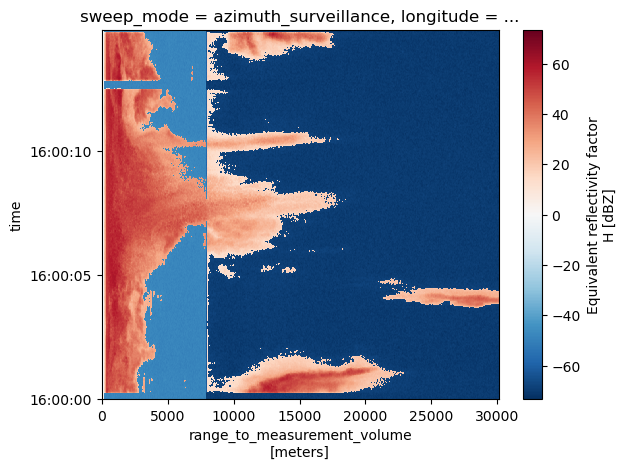

In [24]:
vola = wrl.io.open_odim_dataset(
    "furuno_scn_as_odim.h5", reindex_angle=False, keep_elevation=True
)
display(vola.root)
display(vola[0])
vola[0].DBZH.sortby("rtime").plot(y="rtime")

<xarray.Dataset>
Dimensions:              (sweep: 1)
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2021-07-30T16:00:00Z'
    time_coverage_end    <U20 '2021-07-30 16:00:15Z'
    latitude             float64 ...
    longitude            float64 ...
    altitude             float64 ...
    sweep_group_name     (sweep) <U7 'sweep_0'
    sweep_fixed_angle    (sweep) float64 7.8
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    fixed_angle:      7.8

<xarray.Dataset>
Dimensions:            (azimuth: 1376, range: 602)
Coordinates:
  * azimuth            (azimuth) float32 0.21 0.47 0.74 ... 359.4 359.7 359.9
    elevation          (azimuth) float32 ...
  * range              (range) float32 25.0 75.0 125.0 ... 3.002e+04 3.008e+04
    rtime              (azimuth) datetime64[ns] 2021-07-30T16:00:06.277723500...
    sweep_mode         <U20 ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
    time               datetime64[ns] 2021-07-30T16:00:00.005416500
Data variables: (12/13)
    RATE               (azimuth, range) float32 ...
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    PHIDP              (azimuth, range) float32 ...
    ...                 ...
    WRADH              (azimuth, range) float32 ...
    QUAL               (azimuth, range) uint16 ...
    sweep_number       int64 ...
    prt_mode           object ...
    follow_mode        object ...
    sweep_fixed_angle  float64 7.8
Attributes:
    fixed_angle:  7.8

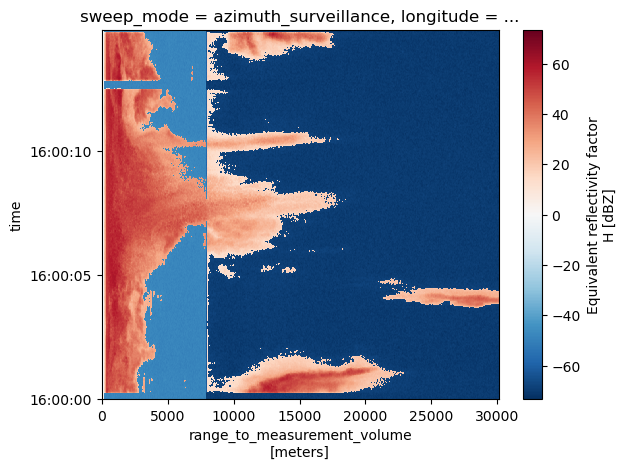

In [25]:
volb = wrl.io.open_cfradial2_dataset("furuno_scn_as_cfradial2.nc")
display(volb.root)
display(volb[0])
volb[0].DBZH.sortby("rtime").plot(y="rtime")

### Check equality

There are slight differences due to importing/exporting and calculation with floating point data.

In [26]:
xr.testing.assert_allclose(vol.root, vola.root)
xr.testing.assert_allclose(
    vol[0].time.astype(float).reset_coords(drop=True),
    vola[0].time.astype(float).reset_coords(drop=True),
)
xr.testing.assert_allclose(
    vol[0].drop_vars(["time", "rtime", "azimuth"]).reset_coords(drop=True),
    vola[0].drop_vars(["time", "rtime", "azimuth"]).reset_coords(drop=True),
)
xr.testing.assert_allclose(
    vol[0].drop_vars(["time", "rtime"]).azimuth.reset_coords(drop=True),
    vola[0].drop_vars(["time", "rtime"]).azimuth.reset_coords(drop=True),
)


xr.testing.assert_allclose(vol.root, volb.root)
xr.testing.assert_allclose(
    vol[0].time.astype(float).reset_coords(drop=True),
    volb[0].time.astype(float).reset_coords(drop=True),
)
xr.testing.assert_allclose(
    vol[0].drop_vars(["time", "rtime", "azimuth"]).reset_coords(drop=True),
    volb[0].drop_vars(["time", "rtime", "azimuth"]).reset_coords(drop=True),
)
xr.testing.assert_allclose(
    vol[0].drop_vars(["time", "rtime"]).azimuth.reset_coords(drop=True),
    volb[0].drop_vars(["time", "rtime"]).azimuth.reset_coords(drop=True),
)

xr.testing.assert_allclose(vola.root, volb.root)
xr.testing.assert_allclose(
    vola[0].time.astype(float).reset_coords(drop=True),
    volb[0].time.astype(float).reset_coords(drop=True),
)
xr.testing.assert_allclose(
    vola[0].drop_vars(["time", "rtime", "azimuth"]).reset_coords(drop=True),
    volb[0].drop_vars(["time", "rtime", "azimuth"]).reset_coords(drop=True),
)
xr.testing.assert_allclose(
    vola[0].drop_vars(["time", "rtime"]).azimuth.reset_coords(drop=True),
    volb[0].drop_vars(["time", "rtime"]).azimuth.reset_coords(drop=True),
)

### Use `xr.open_dataset` to retrieve explicit group

<div class="alert alert-warning">

**Warning** <br>
    
Since $\omega radlib$ version 1.18 the xarray backend engines for polar radar data have been renamed and prepended with `wradlib-` (eg. `furuno` -> `wradlib-furuno`). This was necessary to avoid clashes with the new [xradar](https://github.com/openradar/xradar)-package, which will eventually replace the wradlib engines. Users have to make sure to check which engine to use for their use-case when using `xarray.open_dataset`. Users might install and test `xradar`, and check if it is already robust enough for their use-cases (by using xradar's `engine="furuno"`.
    
Since $\omega radlib$ version 1.19 the xarray backend engines for polar radar data have been deprecated. The functionality is kept until wradlib version 2.0, when the backend-code will be removed completely. wradlib is importing that functionality from [xradar](https://github.com/openradar/xradar)-package whenever and wherever necessary.

Below we use a compatibility layer in wradlib to give users the chance to adapt their code. The first minimal change is that for every backend the group-layout is conforming to the CfRadial-standard naming scheme (``sweep_0``, ``sweep_1``, etc.).
    
</div>

In [27]:
swp = xr.open_dataset(
    f,
    engine="wradlib-furuno",
    group="sweep_0",
    backend_kwargs=dict(reindex_angle=False),
)
display(swp)

<xarray.Dataset>
Dimensions:            (azimuth: 1376, range: 602)
Coordinates:
  * azimuth            (azimuth) float32 0.21 0.47 0.74 ... 359.4 359.7 359.9
    elevation          (azimuth) float32 ...
  * range              (range) float32 25.0 75.0 125.0 ... 3.002e+04 3.008e+04
    rtime              (azimuth) datetime64[ns] ...
    sweep_mode         <U20 ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
    time               datetime64[ns] ...
Data variables: (12/13)
    RATE               (azimuth, range) float32 ...
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    PHIDP              (azimuth, range) float32 ...
    ...                 ...
    WRADH              (azimuth, range) float32 ...
    QUAL               (azimuth, range) uint16 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...
Attributes:
    fixed_angle:  7.8

## Load furuno scnx Data

Data provided by GFZ German Research Centre for Geosciences.

In [28]:
fpath = "furuno/2006_20220324_000000_000.scnx.gz"
f = wrl.util.get_wradlib_data_file(fpath)
vol = wrl.io.open_furuno_dataset(f, reindex_angle=False)

### Inspect RadarVolume

In [29]:
display(vol)

<wradlib.RadarVolume>
Dimension(s): (sweep: 1)
Elevation(s): (0.5)

### Inspect root group

The `sweep` dimension contains the number of scans in this radar volume. Further the dataset consists of variables (location coordinates, time_coverage) and attributes (Conventions, metadata).

In [30]:
vol.root

<xarray.Dataset>
Dimensions:              (sweep: 1)
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2022-03-24T00:00:01Z'
    time_coverage_end    <U20 '2022-03-24 00:00:29Z'
    latitude             float64 ...
    longitude            float64 ...
    altitude             float64 ...
    sweep_group_name     (sweep) <U7 'sweep_0'
    sweep_fixed_angle    (sweep) float64 0.5
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    fixed_angle:      0.5

### Inspect sweep group(s)

The sweep-groups can be accessed via their respective keys. The dimensions consist of `range` and `time` with added coordinates `azimuth`, `elevation`, `range` and `time`. There will be variables like radar moments (DBZH etc.) and sweep-dependend metadata (like `fixed_angle`, `sweep_mode` etc.).

In [31]:
display(vol[0])

<xarray.Dataset>
Dimensions:            (azimuth: 722, range: 936)
Coordinates:
  * azimuth            (azimuth) float32 0.19 0.68 1.16 ... 358.7 359.2 359.7
    elevation          (azimuth) float32 ...
  * range              (range) float32 37.5 112.5 187.5 ... 7.009e+04 7.016e+04
    rtime              (azimuth) datetime64[ns] 2022-03-24T00:00:17.656439500...
    sweep_mode         <U20 ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
    time               datetime64[ns] 2022-03-24T00:00:01.019390500
Data variables: (12/13)
    RATE               (azimuth, range) float32 ...
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    PHIDP              (azimuth, range) float32 ...
    ...                 ...
    WRADH              (azimuth, range) float32 ...
    QUAL               (azimuth, range) uint16 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 0.5
Attributes:
    fixed_angle:  0.5

### Goereferencing

In [32]:
swp = vol[0].copy().pipe(wrl.georef.georeference_dataset)

### Plotting

Currently the data dynamic range is left as read from the file. That way the difference between shortpulse and longpulse can be clearly seen.

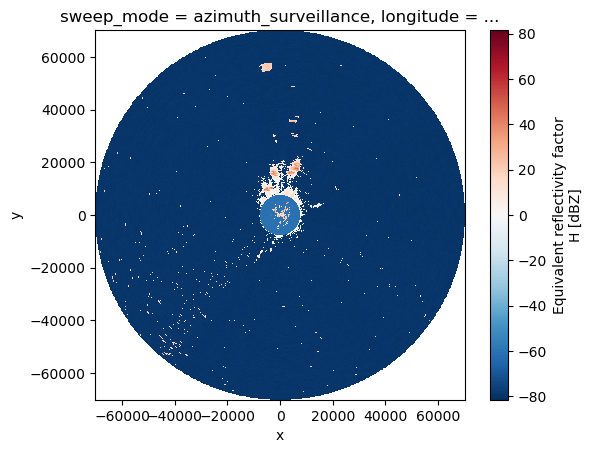

In [33]:
swp.DBZH.plot.pcolormesh(x="x", y="y")
pl.gca().set_aspect("equal")

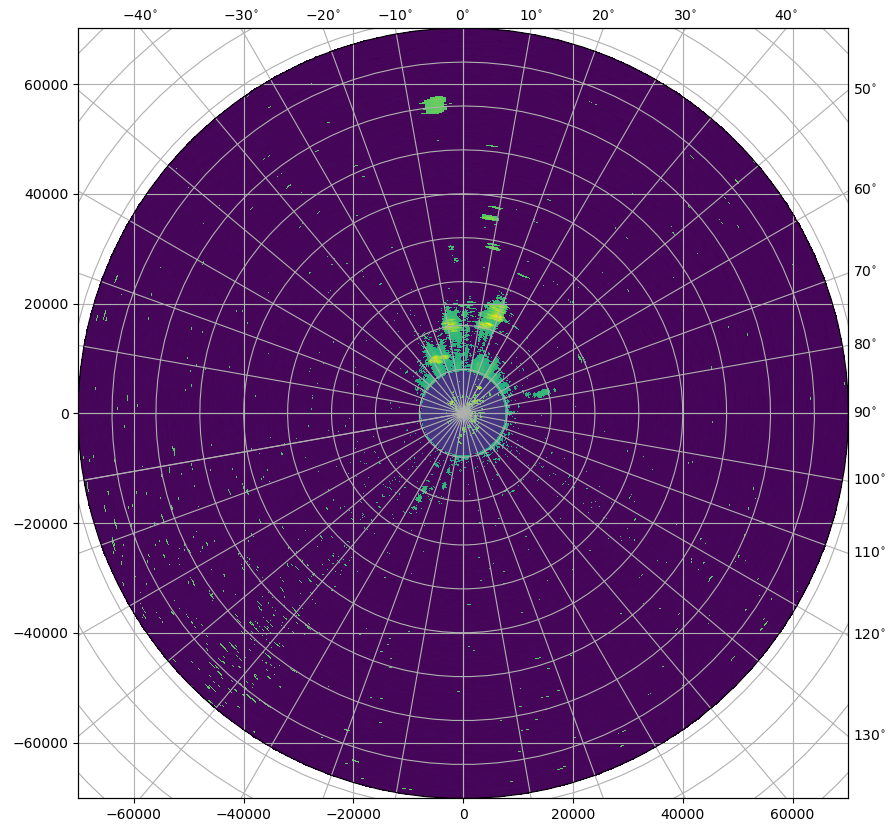

In [34]:
fig = pl.figure(figsize=(10, 10))
swp.DBZH.wradlib.plot_ppi(proj="cg", fig=fig)

In [35]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

map_trans = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values, central_longitude=swp.longitude.values
)

< GeoAxes: +proj=aeqd +ellps=WGS84 +lon_0=13.243970000000001 +lat_0=53.55478 +x_0=0.0 +y_0=0.0 +no_defs +type=crs >


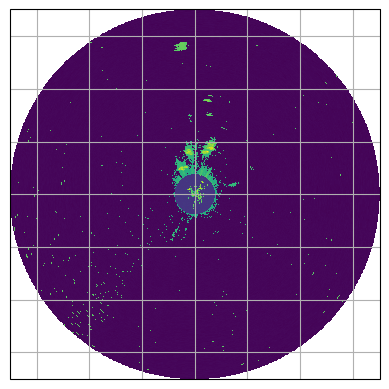

In [36]:
map_proj = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values, central_longitude=swp.longitude.values
)
pm = swp.DBZH.wradlib.plot_ppi(proj=map_proj)
ax = pl.gca()
ax.gridlines(crs=map_proj)
print(ax)

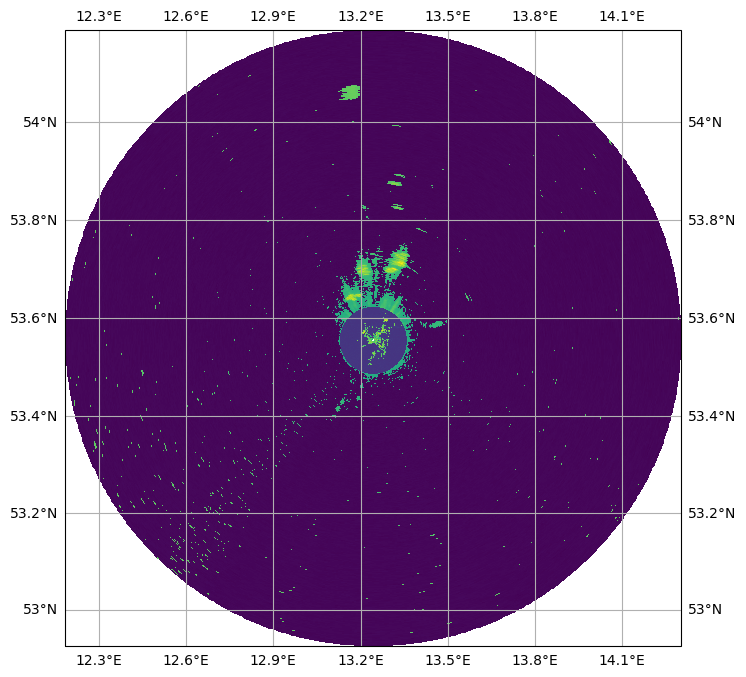

In [37]:
map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)
pm = swp.DBZH.wradlib.plot_ppi(ax=ax)
ax.gridlines(draw_labels=True)

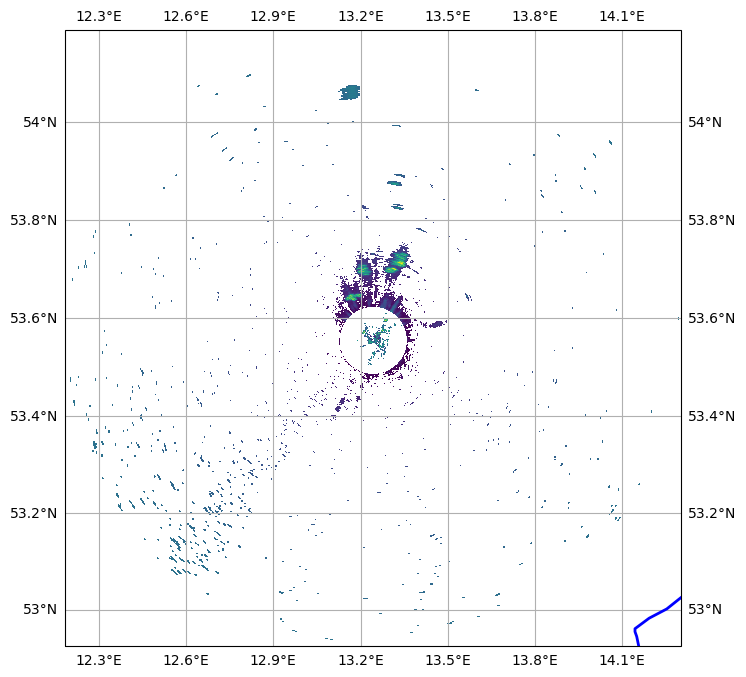

In [38]:
import cartopy.feature as cfeature


def plot_rivers(ax):
    rivers = cfeature.NaturalEarthFeature(
        category="physical",
        name="rivers_lake_centerlines",
        scale="10m",
        facecolor="none",
    )
    ax.add_feature(rivers, edgecolor="blue", lw=2, zorder=4)


map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)

DBZH = swp.DBZH
pm = DBZH.where(DBZH > 0).wradlib.plot_ppi(ax=ax)
plot_rivers(ax)
ax.gridlines(draw_labels=True)

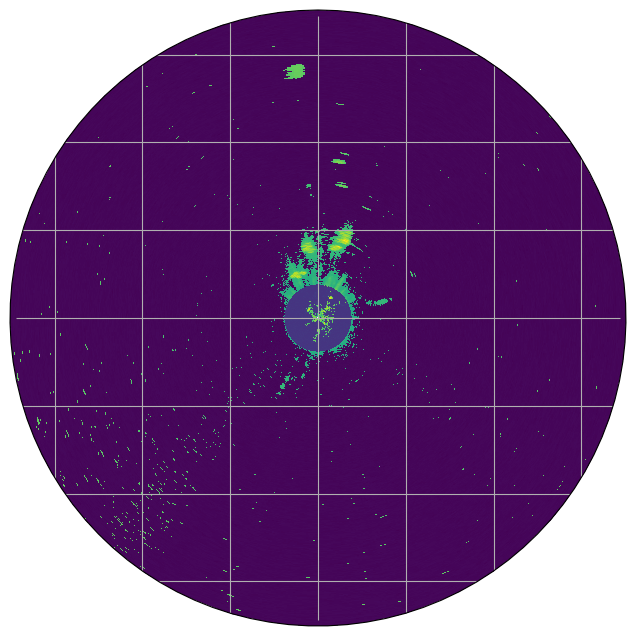

In [39]:
import matplotlib.path as mpath

theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

map_proj = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values,
    central_longitude=swp.longitude.values,
)
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)
ax.set_boundary(circle, transform=ax.transAxes)

pm = swp.DBZH.wradlib.plot_ppi(proj=map_proj, ax=ax)
ax = pl.gca()
ax.gridlines(crs=map_proj)

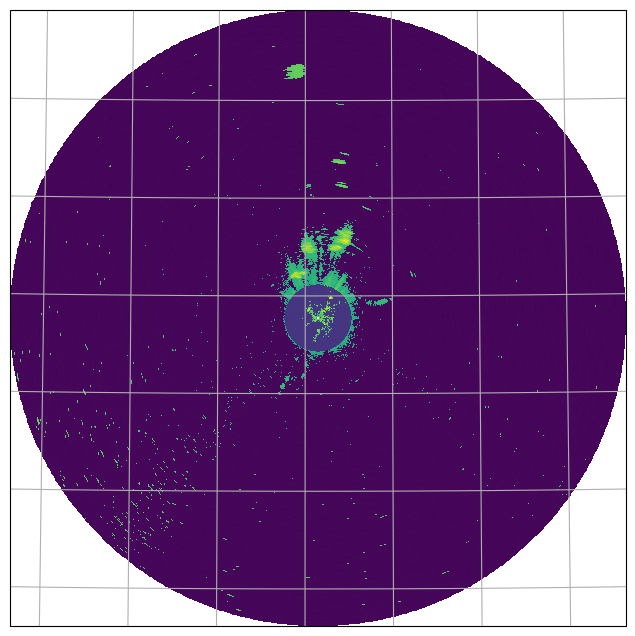

In [40]:
fig = pl.figure(figsize=(10, 8))
proj = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values, central_longitude=swp.longitude.values
)
ax = fig.add_subplot(111, projection=proj)
pm = swp.DBZH.wradlib.plot_ppi(ax=ax)
ax.gridlines()

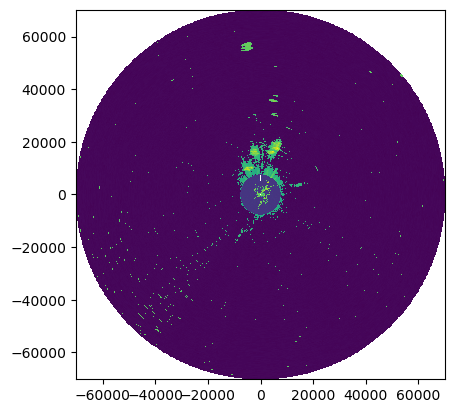

In [41]:
swp.DBZH.wradlib.plot_ppi()

### Inspect radar moments

The DataArrays can be accessed by key or by attribute. Each DataArray has dimensions and coordinates of it's parent dataset.

In [42]:
display(swp.DBZH)

<xarray.DataArray 'DBZH' (azimuth: 722, range: 936)>
array([[       nan,        nan,        nan, ..., -80.740005, -79.34    ,
        -79.240005],
       [       nan,        nan,        nan, ..., -80.31    , -79.06    ,
        -79.25    ],
       [       nan,        nan,        nan, ..., -80.2     , -79.149994,
        -79.31999 ],
       ...,
       [       nan,        nan,        nan, ..., -79.78999 , -79.45999 ,
        -79.      ],
       [       nan,        nan,        nan, ..., -80.09    , -79.31    ,
        -79.020004],
       [       nan,        nan,        nan, ..., -80.369995, -79.33    ,
        -79.149994]], dtype=float32)
Coordinates: (12/15)
  * azimuth     (azimuth) float32 0.19 0.68 1.16 1.69 ... 358.7 359.2 359.7
    elevation   (azimuth) float32 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5 0.5
  * range       (range) float32 37.5 112.5 187.5 ... 7.009e+04 7.016e+04
    rtime       (azimuth) datetime64[ns] 2022-03-24T00:00:17.656439500 ... 20...
    sweep_mode  <U20 'azimuth_surveillance'
    longitude   float64 13.24
    ...          ...
    x           (azimuth, range) float32 0.1244 0.3731 0.6218 ... -403.6 -404.1
    y           (azimuth, range) float32 37.5 112.5 ... 7.008e+04 7.015e+04
    z           (azimuth, range) float32 38.0 39.0 39.0 ... 937.0 939.0 940.0
    gr          (azimuth, range) float32 37.53 112.5 ... 7.008e+04 7.015e+04
    rays        (azimuth, range) float32 0.19 0.19 0.19 ... 359.7 359.7 359.7
    bins        (azimuth, range) float32 37.5 112.5 ... 7.009e+04 7.016e+04
Attributes:
    units:          dBZ
    standard_name:  radar_equivalent_reflectivity_factor_h
    long_name:      Equivalent reflectivity factor H
    coordinates:    elevation azimuth range latitude longitude altitude time ...

### Create simple plot

Using xarray features a simple plot can be created like this. Note the `sortby('rtime')` method, which sorts the radials by time.

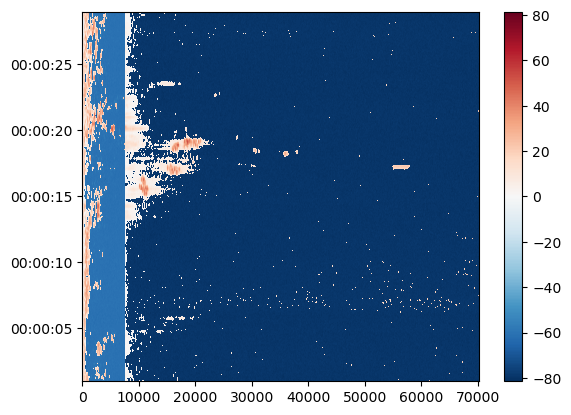

In [43]:
swp.DBZH.sortby("rtime").plot(x="range", y="rtime", add_labels=False)

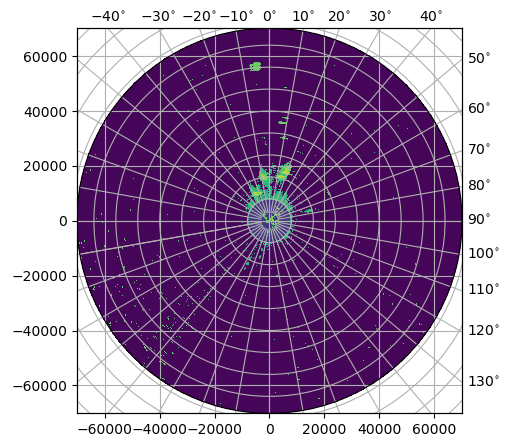

In [44]:
fig = pl.figure(figsize=(5, 5))
pm = swp.DBZH.wradlib.plot_ppi(proj={"latmin": 3e3}, fig=fig)

### Mask some values

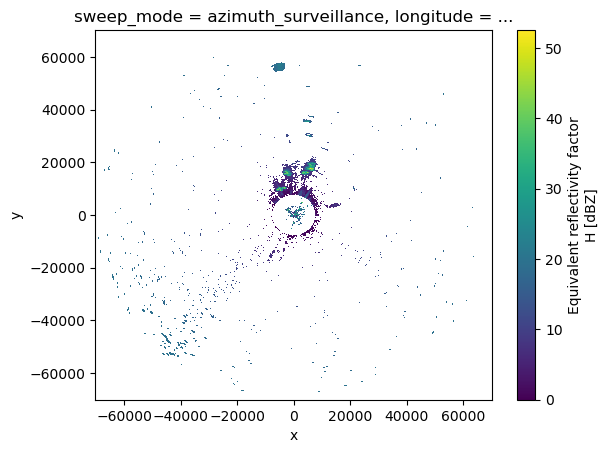

In [45]:
dbzh = swp["DBZH"].where(swp["DBZH"] >= 0)
dbzh.plot(x="x", y="y")

In [46]:
vol[0]

<xarray.Dataset>
Dimensions:            (azimuth: 722, range: 936)
Coordinates:
  * azimuth            (azimuth) float32 0.19 0.68 1.16 ... 358.7 359.2 359.7
    elevation          (azimuth) float32 ...
  * range              (range) float32 37.5 112.5 187.5 ... 7.009e+04 7.016e+04
    rtime              (azimuth) datetime64[ns] 2022-03-24T00:00:17.656439500...
    sweep_mode         <U20 ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
    time               datetime64[ns] 2022-03-24T00:00:01.019390500
Data variables: (12/13)
    RATE               (azimuth, range) float32 ...
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    PHIDP              (azimuth, range) float32 ...
    ...                 ...
    WRADH              (azimuth, range) float32 ...
    QUAL               (azimuth, range) uint16 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 0.5
Attributes:
    fixed_angle:  0.5

### Export to ODIM and CfRadial2


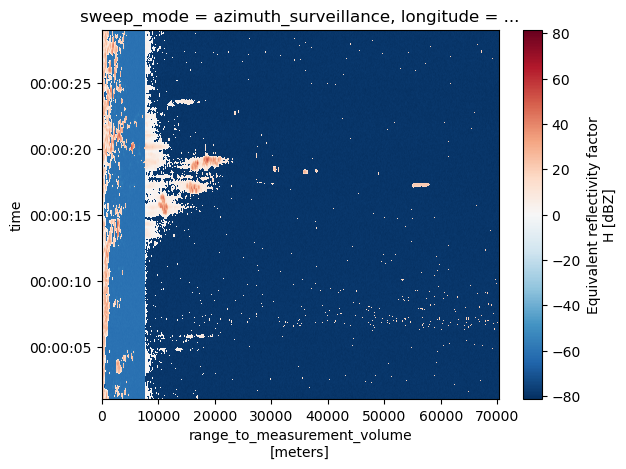

In [47]:
vol[0].DBZH.sortby("rtime").plot(y="rtime")

In [48]:
vol.to_odim("furuno_scnx_as_odim.h5")
vol.to_cfradial2("furuno_scnx_as_cfradial2.nc")

### Import again

<xarray.Dataset>
Dimensions:              (sweep: 1)
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2022-03-24T00:00:01Z'
    time_coverage_end    <U20 '2022-03-24 00:00:29Z'
    latitude             float64 ...
    longitude            float64 ...
    altitude             float64 ...
    sweep_group_name     (sweep) <U7 'sweep_0'
    sweep_fixed_angle    (sweep) float64 0.5
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    fixed_angle:      0.5

<xarray.Dataset>
Dimensions:            (azimuth: 722, range: 936)
Coordinates:
  * azimuth            (azimuth) float32 0.19 0.68 1.16 ... 358.7 359.2 359.7
    elevation          (azimuth) float32 ...
    rtime              (azimuth) datetime64[ns] 2022-03-24T00:00:17.656439552...
  * range              (range) float32 37.5 112.5 187.5 ... 7.009e+04 7.016e+04
    sweep_mode         <U20 ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
    time               datetime64[ns] 2022-03-24T00:00:01.019390464
Data variables: (12/13)
    RATE               (azimuth, range) float32 ...
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    PHIDP              (azimuth, range) float32 ...
    ...                 ...
    WRADH              (azimuth, range) float32 ...
    QUAL               (azimuth, range) uint16 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 0.5
Attributes:
    fixed_angle:  0.5

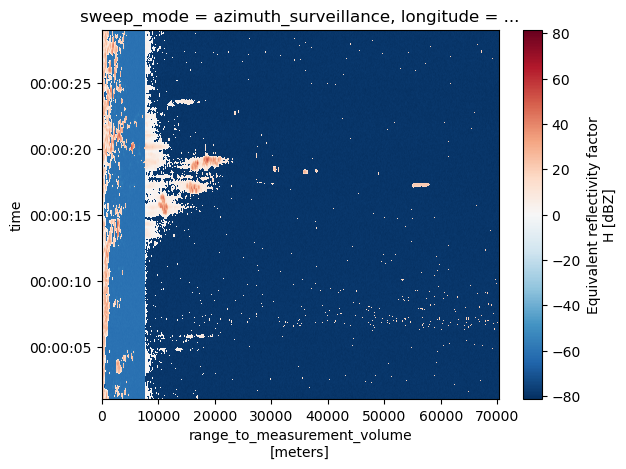

In [49]:
vola = wrl.io.open_odim_dataset(
    "furuno_scnx_as_odim.h5", reindex_angle=False, keep_elevation=True
)
display(vola.root)
display(vola[0])
vola[0].DBZH.sortby("rtime").plot(y="rtime")

<xarray.Dataset>
Dimensions:              (sweep: 1)
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2022-03-24T00:00:01Z'
    time_coverage_end    <U20 '2022-03-24 00:00:29Z'
    latitude             float64 ...
    longitude            float64 ...
    altitude             float64 ...
    sweep_group_name     (sweep) <U7 'sweep_0'
    sweep_fixed_angle    (sweep) float64 0.5
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    fixed_angle:      0.5

<xarray.Dataset>
Dimensions:            (azimuth: 722, range: 936)
Coordinates:
  * azimuth            (azimuth) float32 0.19 0.68 1.16 ... 358.7 359.2 359.7
    elevation          (azimuth) float32 ...
  * range              (range) float32 37.5 112.5 187.5 ... 7.009e+04 7.016e+04
    rtime              (azimuth) datetime64[ns] 2022-03-24T00:00:17.656439500...
    sweep_mode         <U20 ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
    time               datetime64[ns] 2022-03-24T00:00:01.019390500
Data variables: (12/13)
    RATE               (azimuth, range) float32 ...
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    PHIDP              (azimuth, range) float32 ...
    ...                 ...
    WRADH              (azimuth, range) float32 ...
    QUAL               (azimuth, range) uint16 ...
    sweep_number       int64 ...
    prt_mode           object ...
    follow_mode        object ...
    sweep_fixed_angle  float64 0.5
Attributes:
    fixed_angle:  0.5

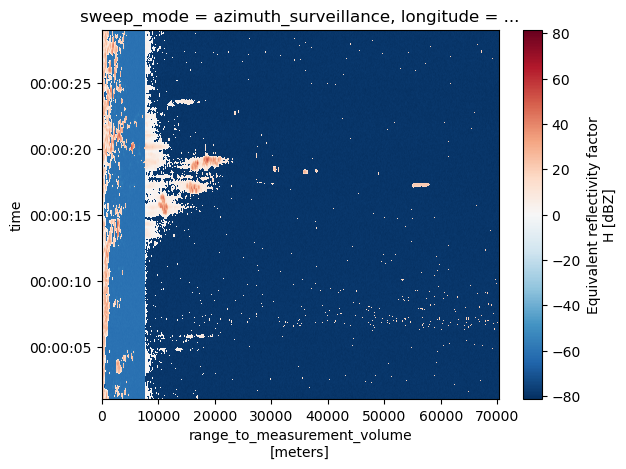

In [50]:
volb = wrl.io.open_cfradial2_dataset("furuno_scnx_as_cfradial2.nc")
display(volb.root)
display(volb[0])
volb[0].DBZH.sortby("rtime").plot(y="rtime")

### Check equality

There are slight differences due to importing/exporting and calculation with floating point data.

In [51]:
xr.testing.assert_allclose(vol.root, vola.root)
xr.testing.assert_allclose(
    vol[0].time.astype(float).reset_coords(drop=True),
    vola[0].time.astype(float).reset_coords(drop=True),
)
xr.testing.assert_allclose(
    vol[0].drop_vars(["time", "rtime", "azimuth"]).reset_coords(drop=True),
    vola[0].drop_vars(["time", "rtime", "azimuth"]).reset_coords(drop=True),
)
xr.testing.assert_allclose(
    vol[0].drop_vars(["time", "rtime"]).azimuth.reset_coords(drop=True),
    vola[0].drop_vars(["time", "rtime"]).azimuth.reset_coords(drop=True),
)


xr.testing.assert_allclose(vol.root, volb.root)
xr.testing.assert_allclose(
    vol[0].time.astype(float).reset_coords(drop=True),
    volb[0].time.astype(float).reset_coords(drop=True),
)
xr.testing.assert_allclose(
    vol[0].drop_vars(["time", "rtime", "azimuth"]).reset_coords(drop=True),
    volb[0].drop_vars(["time", "rtime", "azimuth"]).reset_coords(drop=True),
)
xr.testing.assert_allclose(
    vol[0].drop_vars(["time", "rtime"]).azimuth.reset_coords(drop=True),
    volb[0].drop_vars(["time", "rtime"]).azimuth.reset_coords(drop=True),
)

xr.testing.assert_allclose(vola.root, volb.root)
xr.testing.assert_allclose(
    vola[0].time.astype(float).reset_coords(drop=True),
    volb[0].time.astype(float).reset_coords(drop=True),
)
xr.testing.assert_allclose(
    vola[0].drop_vars(["time", "rtime", "azimuth"]).reset_coords(drop=True),
    volb[0].drop_vars(["time", "rtime", "azimuth"]).reset_coords(drop=True),
)
xr.testing.assert_allclose(
    vola[0].drop_vars(["time", "rtime"]).azimuth.reset_coords(drop=True),
    volb[0].drop_vars(["time", "rtime"]).azimuth.reset_coords(drop=True),
)

## More Furuno loading mechanisms

### Use `xr.open_dataset` to retrieve explicit group

<div class="alert alert-warning">

**Warning** <br>
    
Since $\omega radlib$ version 1.18 the xarray backend engines for polar radar data have been renamed and prepended with `wradlib-` (eg. `furuno` -> `wradlib-furuno`). This was necessary to avoid clashes with the new [xradar](https://github.com/openradar/xradar)-package, which will eventually replace the wradlib engines. Users have to make sure to check which engine to use for their use-case when using `xarray.open_dataset`. Users might install and test `xradar`, and check if it is already robust enough for their use-cases (by using xradar's `engine="furuno"`.
    
Since $\omega radlib$ version 1.19 the xarray backend engines for polar radar data have been deprecated. The functionality is kept until wradlib version 2.0, when the backend-code will be removed completely. wradlib is importing that functionality from [xradar](https://github.com/openradar/xradar)-package whenever and wherever necessary.

Below we use a compatibility layer in wradlib to give users the chance to adapt their code. The first minimal change is that for every backend the group-layout is conforming to the CfRadial-standard naming scheme (``sweep_0``, ``sweep_1``, etc.).
    
</div>

Below you can inspect the main differences of the wradlib compatibility layer and the plain xradar implementation.

### use wradlib compatibility layer

In [52]:
swp_a = xr.open_dataset(
    f, engine="wradlib-furuno", backend_kwargs=dict(reindex_angle=False)
)
display(swp_a)

<xarray.Dataset>
Dimensions:            (azimuth: 722, range: 936)
Coordinates:
  * azimuth            (azimuth) float32 0.19 0.68 1.16 ... 358.7 359.2 359.7
    elevation          (azimuth) float32 ...
  * range              (range) float32 37.5 112.5 187.5 ... 7.009e+04 7.016e+04
    rtime              (azimuth) datetime64[ns] ...
    sweep_mode         <U20 ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
    time               datetime64[ns] ...
Data variables: (12/13)
    RATE               (azimuth, range) float32 ...
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    PHIDP              (azimuth, range) float32 ...
    ...                 ...
    WRADH              (azimuth, range) float32 ...
    QUAL               (azimuth, range) uint16 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...
Attributes:
    fixed_angle:  0.5

### use xradar backend

In [53]:
swp_b = xr.open_dataset(f, engine="furuno", backend_kwargs=dict(reindex_angle=False))
display(swp_b)

<xarray.Dataset>
Dimensions:            (azimuth: 722, range: 936)
Coordinates:
  * azimuth            (azimuth) float32 0.19 0.68 1.16 ... 358.7 359.2 359.7
    elevation          (azimuth) float32 ...
  * range              (range) float32 37.5 112.5 187.5 ... 7.009e+04 7.016e+04
    time               (azimuth) datetime64[ns] ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
Data variables: (12/14)
    RATE               (azimuth, range) float32 ...
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    PHIDP              (azimuth, range) float32 ...
    ...                 ...
    QUAL               (azimuth, range) uint16 ...
    sweep_mode         <U20 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...